<a href="https://colab.research.google.com/github/RoyElkabetz/Text-Summarization-with-Deep-Learning/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Text-Summarization-with-Deep-Learning
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Text-Summarization-with-Deep-Learning")

Cloning into 'Text-Summarization-with-Deep-Learning'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 95 (delta 52), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [2]:
## uncomment if you want to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
PATH_DATASET = '/content/gdrive/MyDrive/Datasets/Text/news_summary_more.csv'
CHECKPOINT_DIR = '/content/gdrive/MyDrive/Checkpoints'
MODEL_NAME = 'LSTM_Text_Summarizer'

In [41]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output

import torch
from torch import nn
import torchtext.legacy.data as data
from torchtext.data.utils import get_tokenizer
from torchtext.legacy.data import Field, Dataset, Example, BucketIterator, Iterator
from torch.utils.data import DataLoader, random_split

# from torchtext.datasets import IMDB as the_dataset
# from torchtext.datasets import AG_NEWS as the_dataset
# import torchtext.data as data
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
# from torchtext.data.functional import to_map_style_dataset
# from torch.utils.data import DataLoader
# from torch.utils.data.dataset import random_split
# from torch import nn




print(f'torch {torch.__version__}')
print('Device properties:')
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_data = torch.cuda.get_device_properties(0)
    gpu_name = gpu_data.name
    gpu_mem  = f'{gpu_data.total_memory * 1e-9:.02f} Gb'
    print(f'GPU: {gpu_name}\nMemory: {gpu_mem}')
else:
    device = torch.device("cpu")
    print('CPU')

torch 1.9.0+cu102
Device properties:
CPU


In [20]:
class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    """Pytorch legacy Dataset: https://pytorch.org/text/_modules/torchtext/data/dataset.html"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
  
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [21]:
data_df = pd.read_csv(PATH_DATASET ,encoding='utf-8')
data_df.drop_duplicates(subset=['text'],inplace=True)  # dropping duplicates
data_df.dropna(axis=0,inplace=True)  # dropping na
data_df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [23]:
## run this if you want to remove stop words from data
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower() # lowercase
    text = text.split() # convert have'nt -> have not
    for i in range(len(text)):
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word]
    text = " ".join(text)
    text = text.split()
    newtext = []
    for word in text:
        if word not in stop_words:
            newtext.append(word)
    text = " ".join(newtext)
    text = text.replace("'s",'') # convert your's -> your
    text = re.sub(r'\(.*\)','',text) # remove (words)
    text = re.sub(r'[^a-zA-Z0-9. ]','',text) # remove punctuations
    text = re.sub(r'\.',' . ',text)
    return text

sample = "(hello) hi there .man tiger caller who's that isn't it ? WALL-E"
print(preprocess(sample))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
 hi  . man tiger caller  walle


In [24]:
# process the data inplace
print('Before preprocessing:\n {}\n {}\n'.format(data_df['headlines'][20], data_df['text'][20]))
data_df['cleaned_headlines'] = data_df['headlines'].apply(lambda x: preprocess(x))
data_df['cleaned_text'] = data_df['text'].apply(lambda x: preprocess(x))
print('After preprocessing:\n {}\n {}\n'.format(data_df['headlines'][20], data_df['text'][20]))
print('After preprocessing:\n {}\n {}\n'.format(data_df['cleaned_headlines'][20], data_df['cleaned_text'][20]))

Before preprocessing:
 I think the opposition even dreams about me: PM Modi
 Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inâ Surat, added that the opposition parties have only one agenda which is "Modi". 

After preprocessing:
 I think the opposition even dreams about me: PM Modi
 Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inâ Surat, added that the opposition parties have only one agenda which is "Modi". 

After preprocessing:
 think opposition even dreams me pm modi
 claiming dearth ideas among opposition parties prime minister narendra modi wednesday said the o

In [25]:
data_df.replace('', np.nan, inplace=True)
data_df.dropna(axis=0, inplace=True)

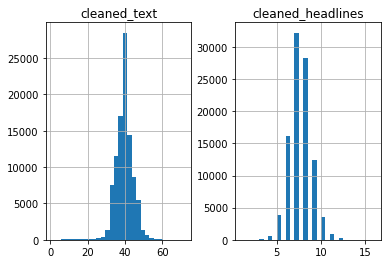

In [27]:
text_word_count = []
headlines_word_count = []

# populate the lists with sentence lengths
for i in data_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data_df['cleaned_headlines']:
      headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'cleaned_text':text_word_count, 'cleaned_headlines':headlines_word_count})
length_df.hist(bins = 30)
plt.show()

In [28]:
cnt = 0
for i in data_df['cleaned_headlines']:
    if(len(i.split()) <= 10):
        cnt += 1
print(cnt / len(data_df['cleaned_headlines']))

0.9874644164294428


In [29]:
max_text_len = 50
max_summary_len = 10

In [30]:
cleaned_text = np.array(data_df['cleaned_text'])
cleaned_summary = np.array(data_df['cleaned_headlines'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df = pd.DataFrame({'text': short_text,'summary': short_summary})

In [31]:
df['summary'] = df['summary'].apply(lambda x: '<sos> '+ x + ' <eos>')

In [32]:
tokenizer = get_tokenizer("basic_english")

# define the text field for the dataset
TEXT = data.Field(sequential=True,
                  lower=True, 
                  tokenize=tokenizer,
                  init_token='<sos>', 
                  eos_token='<eos>',
                  dtype=torch.long)
# define the text field for the dataset
SUMMARY = data.Field(sequential=True,
                    lower=True, 
                    tokenize=tokenizer,
                    init_token='<sos>', 
                    eos_token='<eos>',
                    dtype=torch.long)
#SUMMARY = data.Field(sequential=True, tokenize=tokenizer)
# TEXT.build_vocab(my_data, max_size=25000, vectors="glove.6B.100d") 
#TEXT.build_vocab(my_data, max_size=25000) 
#SUMMARY.build_vocab(my_data)
fields = {'text': TEXT, 'summary': SUMMARY}

In [33]:
train_data, test_data, val_data = DataFrameDataset(df, fields=fields).split(split_ratio=[0.8, 0.1, 0.1])

In [34]:
TEXT.build_vocab(train_data)
SUMMARY.build_vocab(train_data) 

vocab = TEXT.vocab

In [35]:
print(f'Number of train samples: {len(train_data)}')
print(f'Number of validation samples: {len(val_data)}')
print(f'Number of test samples: {len(test_data)}')

# display data samples
display(HTML('<h4>Display data samples:</h4>'))
n_samples = 2
for i in range(n_samples):
    print("\nText:\n ", " ".join([t for t in train_data.examples[i].text]))
    print("Tokens:\n ", [vocab.stoi[t] for t in train_data.examples[i].text])
    print("Summary:\n ", " ".join([t for t in train_data.examples[i].summary]))
    print("Tokens:\n ", [vocab.stoi[t] for t in train_data.examples[i].summary])

Number of train samples: 76906
Number of validation samples: 9613
Number of test samples: 9613



Text:
  wishing luck wife squash player dipika pallikal upcoming commonwealth games indian wicketkeeper dinesh karthik tweeted to able support wife achieve goals everything me . make memories importantly enjoy moment karthik wrote twitter post wishing wife indian athletes .
Tokens:
  [3003, 6216, 177, 11419, 342, 11858, 21672, 182, 1962, 549, 14, 2857, 3101, 3932, 79, 896, 697, 357, 177, 2403, 1654, 1696, 520, 4, 126, 7508, 14697, 4178, 1876, 3932, 100, 134, 216, 3003, 177, 14, 3056, 4]
Summary:
  <sos> support everything karthik wife ahead cwg <eos>
Tokens:
  [2, 357, 1696, 3932, 177, 391, 5742, 3]

Text:
  priyanka chopra debut hollywood film baywatch set release india june 2 currently 15 rating american review aggregator site rotten tomatoes . 46 reviews critic consensus states baywatch takes source material jiggle factor rrated levels lacks original campy charm leaves charming stars flailing shallows .
Tokens:
  [555, 679, 571, 1236, 15, 10684, 137, 219, 7, 421, 110, 358, 247, 324

In [36]:
print(vars(train_data.examples[-1]))

{'text': ['national', 'security', 'adviser', 'ajit', 'doval', 'central', 'vigilance', 'commissioner', 'kv', 'chaudhary', 'interfered', 'corruption', 'investigation', 'cbi', 'special', 'director', 'rakesh', 'asthana', 'cbi', 'officer', 'mk', 'sinha', 'told', 'supreme', 'court', 'monday', '.', 'allow', 'searches', 'important', 'inquiry', 'sinha', 'added', '.', 'sinha', 'also', 'said', 'union', 'minister', 'haribhai', 'parthibhai', 'chaudhary', 'took', 'a', 'crores', 'help', 'businessman', '.'], 'summary': ['<sos>', 'ajit', 'doval', 'interfered', 'probe', 'cbi', 'asthana', 'officer', 'sc', '<eos>']}


In [39]:
BATCH_SIZE = 100

train_iterator, valid_iterator, test_iterator = Iterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device, 
    sort_key=lambda x: len(x.text))

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        # initializations
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # we will use 2 layers for both encoder and decoder
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        return hidden, cell
 



class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        # initialize
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # for decoder we will use n_directions 1
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        # fully connected layer to predict words
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, hidden, cell):
        
        #trg = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        trg = trg.unsqueeze(0)
        
        #trg = [1, batch size]
        embedded = self.dropout(self.embedding(trg))
        
        #embedded = [1, batch size, emb dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

    

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size] where src_len is number of tokens in source sentence
        #trg = [trg len, batch size] same for trg_len
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim # we don't have trg.shape[-1] here
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(dec_input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            dec_input = trg[t] if teacher_force else top1
        
        return outputs

In [43]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(SUMMARY.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# initialize seq2seq model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device)